In [1]:
# Install required packages
%pip install -q torch torchvision opencv-python-headless scikit-learn matplotlib tqdm pillow scipy PyWavelets

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# =============================================================================
# Cell 1: Imports and Setup
# =============================================================================
import os
import sys
import io
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from torch.optim.lr_scheduler import OneCycleLR
from torch.cuda.amp import GradScaler, autocast

import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import precision_recall_curve
import random
from typing import Dict, List, Tuple

# Configuration
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")
print(f"PyTorch version: {torch.__version__}")

# Global settings
CONFIG = {
    'data_path': '../data/CASIA2',  # Update this path
    'batch_size': 8,
    'image_size': (256, 256),
    'num_epochs': 100,
    'learning_rate': 3e-4,
    'num_workers': 2 if DEVICE == 'cuda' else 0,
    'seed': 42
}

# Set seeds for reproducibility
torch.manual_seed(CONFIG['seed'])
np.random.seed(CONFIG['seed'])
random.seed(CONFIG['seed'])
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(CONFIG['seed'])

print("\nConfiguration:")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")

Using device: cuda
PyTorch version: 2.5.1

Configuration:
  data_path: ../data/CASIA2
  batch_size: 8
  image_size: (256, 256)
  num_epochs: 100
  learning_rate: 0.0003
  num_workers: 2
  seed: 42


In [3]:
# =============================================================================
# Cell 2: Model Architecture Components
# =============================================================================

class DoubleConv(nn.Module):
    """Basic double convolution block"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout),
            nn.Conv2d(out_channels, out_channels, 3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module):
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels, dropout)
        )
    
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module):
    """Upscaling then double conv"""
    def __init__(self, in_channels, out_channels, dropout=0.1):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, 2, stride=2)
        self.conv = DoubleConv(in_channels, out_channels, dropout)
    
    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # Pad if needed
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class SimpleUNet(nn.Module):
    """Lightweight U-Net - FIXED CHANNELS"""
    def __init__(self, n_channels=4, n_classes=1, dropout=0.15):
        super().__init__()
        
        # Encoder
        self.inc = DoubleConv(n_channels, 64, dropout)
        self.down1 = Down(64, 128, dropout)
        self.down2 = Down(128, 256, dropout)
        self.down3 = Down(256, 512, dropout)
        
        # Bottleneck - produces 1024 channels
        self.down4 = Down(512, 1024, dropout)
        
        # Decoder - now channels match
        self.up1 = Up(1024, 512, dropout)  # 1024 -> 512
        self.up2 = Up(512, 256, dropout)   # 512 -> 256
        self.up3 = Up(256, 128, dropout)   # 256 -> 128
        self.up4 = Up(128, 64, dropout)    # 128 -> 64
        
        self.outc = nn.Conv2d(64, n_classes, 1)
    
    def forward(self, x):
        # Encoder
        x1 = self.inc(x)      # 64 channels
        x2 = self.down1(x1)   # 128 channels
        x3 = self.down2(x2)   # 256 channels
        x4 = self.down3(x3)   # 512 channels
        x5 = self.down4(x4)   # 1024 channels (bottleneck)
        
        # Decoder
        x = self.up1(x5, x4)  # 1024 + 512 -> 512
        x = self.up2(x, x3)   # 512 + 256 -> 256
        x = self.up3(x, x2)   # 256 + 128 -> 128
        x = self.up4(x, x1)   # 128 + 64 -> 64
        
        return self.outc(x)   # 64 -> 1

In [4]:
# =============================================================================
# Cell 3: Loss Functions
# =============================================================================

class TverskyLoss(nn.Module):
    """Tversky loss for handling class imbalance"""
    def __init__(self, alpha=0.7, beta=0.3, smooth=1e-5):
        super().__init__()
        self.alpha = alpha
        self.beta = beta
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        tp = (inputs * targets).sum()
        fp = (inputs * (1 - targets)).sum()
        fn = ((1 - inputs) * targets).sum()
        
        tversky = (tp + self.smooth) / (tp + self.alpha * fp + self.beta * fn + self.smooth)
        return 1 - tversky

class DiceLoss(nn.Module):
    """Dice Loss"""
    def __init__(self, smooth=1.0):
        super().__init__()
        self.smooth = smooth
    
    def forward(self, inputs, targets):
        inputs = torch.sigmoid(inputs)
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()
        dice = (2. * intersection + self.smooth) / (inputs.sum() + targets.sum() + self.smooth)
        
        return 1 - dice

class CombinedLoss(nn.Module):
    """Combined loss function"""
    def __init__(self, bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4):
        super().__init__()
        self.bce_weight = bce_weight
        self.dice_weight = dice_weight
        self.tversky_weight = tversky_weight
        
        self.bce = nn.BCEWithLogitsLoss()
        self.dice = DiceLoss()
        self.tversky = TverskyLoss(alpha=0.7, beta=0.3)
    
    def forward(self, inputs, targets):
        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        tversky_loss = self.tversky(inputs, targets)
        
        total = (self.bce_weight * bce_loss + 
                self.dice_weight * dice_loss + 
                self.tversky_weight * tversky_loss)
        
        return total, {
            'bce': bce_loss.item(),
            'dice': dice_loss.item(),
            'tversky': tversky_loss.item(),
            'total': total.item()
        }

In [5]:
# =============================================================================
# Cell 4: Data Loading and ELA Generation
# =============================================================================

def generate_ela(image, quality=90, scale=15):
    """Generate Error Level Analysis"""
    if isinstance(image, np.ndarray):
        pil_image = Image.fromarray(image.astype(np.uint8))
    else:
        pil_image = image
    
    if pil_image.mode != 'RGB':
        pil_image = pil_image.convert('RGB')
    
    buffer = io.BytesIO()
    pil_image.save(buffer, format='JPEG', quality=quality)
    buffer.seek(0)
    compressed = Image.open(buffer)
    
    original_np = np.array(pil_image, dtype=np.float32)
    compressed_np = np.array(compressed, dtype=np.float32)
    
    diff = np.abs(original_np - compressed_np)
    ela = np.clip(diff * scale, 0, 255).astype(np.uint8)
    ela_gray = cv2.cvtColor(ela, cv2.COLOR_RGB2GRAY)
    
    return ela_gray

class ForgeryDataset(Dataset):
    """Dataset for forgery detection"""
    def __init__(self, root_dir, image_size=(256, 256), train=True):
        self.root_dir = root_dir
        self.image_size = image_size
        self.train = train
        
        self.tampered_path = os.path.join(root_dir, 'Tp')
        self.groundtruth_path = os.path.join(root_dir, 'CASIA 2 Groundtruth')
        
        self.pairs = self._find_pairs()
        
        self.normalize_mean = np.array([0.485, 0.456, 0.406])
        self.normalize_std = np.array([0.229, 0.224, 0.225])
    
    def _find_pairs(self):
        pairs = []
        
        if not os.path.exists(self.tampered_path):
            return pairs
        
        if not os.path.exists(self.groundtruth_path):
            return pairs
        
        for img_file in os.listdir(self.tampered_path):
            if img_file.endswith(('.jpg', '.tif', '.bmp', '.png')):
                base_name = os.path.splitext(img_file)[0]
                mask_name = base_name + '_gt.png'
                mask_path = os.path.join(self.groundtruth_path, mask_name)
                
                if os.path.exists(mask_path):
                    img_path = os.path.join(self.tampered_path, img_file)
                    pairs.append((img_path, mask_path))
        
        return pairs
    
    def __len__(self):
        return len(self.pairs) if self.pairs else 100  # Fallback for demo
    
    def __getitem__(self, idx):
        if not self.pairs:
            # Generate synthetic data if no real data available
            image = np.random.randint(0, 255, (*self.image_size, 3), dtype=np.uint8)
            mask = np.random.binomial(1, 0.2, self.image_size).astype(np.float32)
            ela = np.random.randint(0, 100, self.image_size, dtype=np.uint8)
        else:
            img_path, mask_path = self.pairs[idx]
            
            image = cv2.imread(img_path)
            if image is None:
                return self.__getitem__(random.randint(0, len(self) - 1))
            
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            mask = cv2.imread(mask_path, 0)
            
            if mask is None:
                return self.__getitem__(random.randint(0, len(self) - 1))
            
            ela = generate_ela(image)
            
            # Resize
            image = cv2.resize(image, self.image_size)
            mask = cv2.resize(mask, self.image_size, interpolation=cv2.INTER_NEAREST)
            ela = cv2.resize(ela, self.image_size)
            
            # Augmentation for training
            if self.train and random.random() > 0.5:
                image = cv2.flip(image, 1)
                mask = cv2.flip(mask, 1)
                ela = cv2.flip(ela, 1)
        
        # Normalize and convert to tensors
        image = image.astype(np.float32) / 255.0
        ela = ela.astype(np.float32) / 255.0
        mask = mask.astype(np.float32) / 255.0
        
        image = (image - self.normalize_mean) / self.normalize_std
        
        image = torch.from_numpy(image).permute(2, 0, 1).float()
        ela = torch.from_numpy(ela).unsqueeze(0).float()
        mask = torch.from_numpy(mask).unsqueeze(0).float()
        
        combined = torch.cat([image, ela], dim=0)
        mask = (mask > 0.5).float()
        
        return combined, mask

In [6]:
# =============================================================================
# Cell 5: Training Functinons
# =============================================================================

def calculate_metrics(predictions, targets, threshold=0.5):
    """Calculate evaluation metrics"""
    preds_binary = (predictions > threshold).float()
    targets_binary = (targets > 0.5).float()
    
    preds_flat = preds_binary.view(-1)
    targets_flat = targets_binary.view(-1)
    
    tp = (preds_flat * targets_flat).sum().item()
    fp = (preds_flat * (1 - targets_flat)).sum().item()
    fn = ((1 - preds_flat) * targets_flat).sum().item()
    tn = ((1 - preds_flat) * (1 - targets_flat)).sum().item()
    
    epsilon = 1e-7
    
    precision = tp / (tp + fp + epsilon)
    recall = tp / (tp + fn + epsilon)
    f1 = 2 * precision * recall / (precision + recall + epsilon)
    iou = tp / (tp + fp + fn + epsilon)
    accuracy = (tp + tn) / (tp + tn + fp + fn + epsilon)
    
    return {
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'iou': iou,
        'accuracy': accuracy
    }

In [7]:
# =============================================================================
# Cell 6: Create Data Loaders
# =============================================================================

# Create dataset
dataset = ForgeryDataset(CONFIG['data_path'], CONFIG['image_size'], train=True)
val_dataset = ForgeryDataset(CONFIG['data_path'], CONFIG['image_size'], train=False)

# Split dataset
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

indices = list(range(total_size))
random.shuffle(indices)

train_indices = indices[:train_size]
val_indices = indices[train_size:train_size+val_size]
test_indices = indices[train_size+val_size:]

train_subset = Subset(dataset, train_indices)
val_subset = Subset(val_dataset, val_indices)
test_subset = Subset(val_dataset, test_indices)

# Create loaders
train_loader = DataLoader(train_subset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=0)
val_loader = DataLoader(val_subset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)
test_loader = DataLoader(test_subset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=0)

print(f"Dataset sizes:")
print(f"  Train: {len(train_subset)}")
print(f"  Val: {len(val_subset)}")
print(f"  Test: {len(test_subset)}")

Dataset sizes:
  Train: 3486
  Val: 747
  Test: 748


In [8]:
# =============================================================================
# Cell 7: Initialise Model
# =============================================================================

model = SimpleUNet(n_channels=4, n_classes=1, dropout=0.15).to(DEVICE)
criterion = CombinedLoss(bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4)
optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)

total_params = sum(p.numel() for p in model.parameters())
print(f"\nModel initialized:")
print(f"  Total parameters: {total_params:,}")
print(f"  Device: {DEVICE}")

# Memory check for CUDA
if torch.cuda.is_available():
    print(f"  GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")
    print(f"  GPU Name: {torch.cuda.get_device_name(0)}")


Model initialized:
  Total parameters: 31,038,209
  Device: cuda
  GPU Memory: 17.17 GB
  GPU Name: NVIDIA GeForce RTX 4080


In [9]:
# =============================================================================
# Cell 8: Training Loop
# =============================================================================

DEMO_MODE = False  # Set to False for full training
num_epochs = 3 if DEMO_MODE else CONFIG['num_epochs']

print(f"\n{'='*70}")
print("ENSEMBLE TRAINING - 3 Models with Different Seeds")
print(f"{'='*70}\n")

ensemble_models = []
ensemble_histories = []

for model_idx, seed in enumerate([42, 123, 456]):
    print(f"\n{'='*70}")
    print(f"Training Model {model_idx + 1}/3 (Seed: {seed})")
    print(f"{'='*70}\n")
    
    # Set seed for this model
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
    
    # Create fresh model
    model = SimpleUNet(n_channels=4, n_classes=1, dropout=0.15).to(DEVICE)
    criterion = CombinedLoss(bce_weight=0.2, dice_weight=0.4, tversky_weight=0.4)
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=1e-4)
    
    best_val_iou = 0
    history = {'train_loss': [], 'val_loss': [], 'val_iou': []}
    
    # Training loop for this model
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0
        
        loop = tqdm(train_loader, desc=f"Model {model_idx+1} - Epoch {epoch+1}/{num_epochs}")
        for batch_idx, (data, targets) in enumerate(loop):
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            
            optimizer.zero_grad()
            outputs = model(data)
            loss, _ = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
            loop.set_postfix(loss=loss.item())
            
            if DEMO_MODE and batch_idx >= 5:
                break
        
        # Validation phase
        model.eval()
        val_loss = 0
        val_ious = []
        
        with torch.no_grad():
            for batch_idx, (data, targets) in enumerate(val_loader):
                data, targets = data.to(DEVICE), targets.to(DEVICE)
                outputs = model(data)
                loss, _ = criterion(outputs, targets)
                val_loss += loss.item()
                
                preds = torch.sigmoid(outputs)
                metrics = calculate_metrics(preds, targets)
                val_ious.append(metrics['iou'])
                
                if DEMO_MODE and batch_idx >= 3:
                    break
        
        avg_train_loss = train_loss / min(len(train_loader), 6 if DEMO_MODE else len(train_loader))
        avg_val_loss = val_loss / min(len(val_loader), 4 if DEMO_MODE else len(val_loader))
        avg_val_iou = np.mean(val_ious)
        
        history['train_loss'].append(avg_train_loss)
        history['val_loss'].append(avg_val_loss)
        history['val_iou'].append(avg_val_iou)
        
        print(f"  Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}, Val IoU={avg_val_iou:.4f}")
        
        if avg_val_iou > best_val_iou:
            best_val_iou = avg_val_iou
            torch.save(model.state_dict(), f'best_model_{model_idx+1}.pth')
    
    print(f"\nModel {model_idx+1} complete! Best IoU: {best_val_iou:.4f}")
    
    # Load best checkpoint for this model
    model.load_state_dict(torch.load(f'best_model_{model_idx+1}.pth', map_location=DEVICE))
    
    ensemble_models.append(model)
    ensemble_histories.append(history)

print(f"\n{'='*70}")
print("ENSEMBLE TRAINING COMPLETE")
print(f"{'='*70}")
print("\nIndividual model best IoUs:")
for i, hist in enumerate(ensemble_histories):
    print(f"  Model {i+1}: {max(hist['val_iou']):.4f}")


ENSEMBLE TRAINING - 3 Models with Different Seeds


Training Model 1/3 (Seed: 42)



Model 1 - Epoch 1/100: 100%|██████████| 436/436 [01:37<00:00,  4.49it/s, loss=0.656]


  Epoch 1: Train Loss=0.7449, Val Loss=0.6960, Val IoU=0.1584


Model 1 - Epoch 2/100: 100%|██████████| 436/436 [01:32<00:00,  4.71it/s, loss=0.794]


  Epoch 2: Train Loss=0.6848, Val Loss=0.6544, Val IoU=0.1946


Model 1 - Epoch 3/100: 100%|██████████| 436/436 [01:32<00:00,  4.72it/s, loss=0.388]


  Epoch 3: Train Loss=0.6326, Val Loss=0.5863, Val IoU=0.2456


Model 1 - Epoch 4/100: 100%|██████████| 436/436 [01:32<00:00,  4.73it/s, loss=0.399]


  Epoch 4: Train Loss=0.5937, Val Loss=0.5638, Val IoU=0.2765


Model 1 - Epoch 5/100: 100%|██████████| 436/436 [01:33<00:00,  4.64it/s, loss=0.549]


  Epoch 5: Train Loss=0.5701, Val Loss=0.5774, Val IoU=0.2610


Model 1 - Epoch 6/100: 100%|██████████| 436/436 [01:32<00:00,  4.70it/s, loss=0.57] 


  Epoch 6: Train Loss=0.5476, Val Loss=0.5110, Val IoU=0.3079


Model 1 - Epoch 7/100: 100%|██████████| 436/436 [01:35<00:00,  4.59it/s, loss=0.736]


  Epoch 7: Train Loss=0.5357, Val Loss=0.5275, Val IoU=0.2868


Model 1 - Epoch 8/100: 100%|██████████| 436/436 [01:34<00:00,  4.64it/s, loss=0.833]


  Epoch 8: Train Loss=0.5139, Val Loss=0.4700, Val IoU=0.3463


Model 1 - Epoch 9/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.376]


  Epoch 9: Train Loss=0.5112, Val Loss=0.4710, Val IoU=0.3562


Model 1 - Epoch 10/100: 100%|██████████| 436/436 [01:37<00:00,  4.47it/s, loss=0.451]


  Epoch 10: Train Loss=0.5044, Val Loss=0.4457, Val IoU=0.3715


Model 1 - Epoch 11/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.363]


  Epoch 11: Train Loss=0.4825, Val Loss=0.4379, Val IoU=0.3883


Model 1 - Epoch 12/100: 100%|██████████| 436/436 [01:59<00:00,  3.64it/s, loss=0.359]


  Epoch 12: Train Loss=0.4747, Val Loss=0.4175, Val IoU=0.3999


Model 1 - Epoch 13/100: 100%|██████████| 436/436 [02:30<00:00,  2.89it/s, loss=0.268]


  Epoch 13: Train Loss=0.4662, Val Loss=0.4340, Val IoU=0.3845


Model 1 - Epoch 14/100: 100%|██████████| 436/436 [01:56<00:00,  3.74it/s, loss=0.566]


  Epoch 14: Train Loss=0.4658, Val Loss=0.4040, Val IoU=0.4212


Model 1 - Epoch 15/100: 100%|██████████| 436/436 [01:51<00:00,  3.90it/s, loss=0.194]


  Epoch 15: Train Loss=0.4469, Val Loss=0.4453, Val IoU=0.3731


Model 1 - Epoch 16/100: 100%|██████████| 436/436 [02:37<00:00,  2.77it/s, loss=0.729] 


  Epoch 16: Train Loss=0.4481, Val Loss=0.3998, Val IoU=0.4151


Model 1 - Epoch 17/100: 100%|██████████| 436/436 [01:52<00:00,  3.88it/s, loss=0.127] 


  Epoch 17: Train Loss=0.4256, Val Loss=0.3832, Val IoU=0.4373


Model 1 - Epoch 18/100: 100%|██████████| 436/436 [02:16<00:00,  3.19it/s, loss=0.49]  


  Epoch 18: Train Loss=0.4369, Val Loss=0.3753, Val IoU=0.4511


Model 1 - Epoch 19/100: 100%|██████████| 436/436 [01:47<00:00,  4.05it/s, loss=0.326]


  Epoch 19: Train Loss=0.4220, Val Loss=0.3786, Val IoU=0.4428


Model 1 - Epoch 20/100: 100%|██████████| 436/436 [01:50<00:00,  3.95it/s, loss=0.471] 


  Epoch 20: Train Loss=0.4148, Val Loss=0.3838, Val IoU=0.4403


Model 1 - Epoch 21/100: 100%|██████████| 436/436 [01:49<00:00,  3.97it/s, loss=0.39] 


  Epoch 21: Train Loss=0.4138, Val Loss=0.3706, Val IoU=0.4612


Model 1 - Epoch 22/100: 100%|██████████| 436/436 [01:51<00:00,  3.91it/s, loss=0.598] 


  Epoch 22: Train Loss=0.4019, Val Loss=0.3719, Val IoU=0.4478


Model 1 - Epoch 23/100: 100%|██████████| 436/436 [01:51<00:00,  3.93it/s, loss=0.148] 


  Epoch 23: Train Loss=0.4010, Val Loss=0.3665, Val IoU=0.4525


Model 1 - Epoch 24/100: 100%|██████████| 436/436 [01:47<00:00,  4.04it/s, loss=0.201] 


  Epoch 24: Train Loss=0.4051, Val Loss=0.3860, Val IoU=0.4496


Model 1 - Epoch 25/100: 100%|██████████| 436/436 [01:56<00:00,  3.73it/s, loss=0.229] 


  Epoch 25: Train Loss=0.3932, Val Loss=0.3785, Val IoU=0.4550


Model 1 - Epoch 26/100: 100%|██████████| 436/436 [01:56<00:00,  3.76it/s, loss=0.178] 


  Epoch 26: Train Loss=0.3878, Val Loss=0.3577, Val IoU=0.4670


Model 1 - Epoch 27/100: 100%|██████████| 436/436 [01:57<00:00,  3.71it/s, loss=0.306] 


  Epoch 27: Train Loss=0.3756, Val Loss=0.3393, Val IoU=0.4953


Model 1 - Epoch 28/100: 100%|██████████| 436/436 [01:55<00:00,  3.78it/s, loss=0.26]  


  Epoch 28: Train Loss=0.3878, Val Loss=0.3602, Val IoU=0.4615


Model 1 - Epoch 29/100: 100%|██████████| 436/436 [01:53<00:00,  3.83it/s, loss=0.381] 


  Epoch 29: Train Loss=0.3731, Val Loss=0.3409, Val IoU=0.4977


Model 1 - Epoch 30/100: 100%|██████████| 436/436 [01:51<00:00,  3.91it/s, loss=0.238] 


  Epoch 30: Train Loss=0.3715, Val Loss=0.3659, Val IoU=0.4776


Model 1 - Epoch 31/100: 100%|██████████| 436/436 [01:50<00:00,  3.94it/s, loss=0.2]   


  Epoch 31: Train Loss=0.3624, Val Loss=0.4695, Val IoU=0.3515


Model 1 - Epoch 32/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.615] 


  Epoch 32: Train Loss=0.3571, Val Loss=0.3288, Val IoU=0.5011


Model 1 - Epoch 33/100: 100%|██████████| 436/436 [01:46<00:00,  4.09it/s, loss=0.715] 


  Epoch 33: Train Loss=0.3552, Val Loss=0.3394, Val IoU=0.4821


Model 1 - Epoch 34/100: 100%|██████████| 436/436 [01:46<00:00,  4.10it/s, loss=0.103] 


  Epoch 34: Train Loss=0.3552, Val Loss=0.3311, Val IoU=0.5005


Model 1 - Epoch 35/100: 100%|██████████| 436/436 [01:51<00:00,  3.92it/s, loss=0.468] 


  Epoch 35: Train Loss=0.3573, Val Loss=0.3366, Val IoU=0.4927


Model 1 - Epoch 36/100: 100%|██████████| 436/436 [01:53<00:00,  3.86it/s, loss=0.191] 


  Epoch 36: Train Loss=0.3487, Val Loss=0.3132, Val IoU=0.5237


Model 1 - Epoch 37/100: 100%|██████████| 436/436 [01:52<00:00,  3.87it/s, loss=0.469] 


  Epoch 37: Train Loss=0.3455, Val Loss=0.3286, Val IoU=0.4946


Model 1 - Epoch 38/100: 100%|██████████| 436/436 [01:46<00:00,  4.11it/s, loss=0.796] 


  Epoch 38: Train Loss=0.3441, Val Loss=0.3173, Val IoU=0.5162


Model 1 - Epoch 39/100: 100%|██████████| 436/436 [01:48<00:00,  4.02it/s, loss=0.371] 


  Epoch 39: Train Loss=0.3483, Val Loss=0.3105, Val IoU=0.5219


Model 1 - Epoch 40/100: 100%|██████████| 436/436 [01:49<00:00,  3.99it/s, loss=0.55]  


  Epoch 40: Train Loss=0.3330, Val Loss=0.3155, Val IoU=0.5162


Model 1 - Epoch 41/100: 100%|██████████| 436/436 [01:52<00:00,  3.88it/s, loss=0.701] 


  Epoch 41: Train Loss=0.3262, Val Loss=0.3091, Val IoU=0.5268


Model 1 - Epoch 42/100: 100%|██████████| 436/436 [01:52<00:00,  3.87it/s, loss=0.193] 


  Epoch 42: Train Loss=0.3322, Val Loss=0.3069, Val IoU=0.5328


Model 1 - Epoch 43/100: 100%|██████████| 436/436 [01:50<00:00,  3.95it/s, loss=0.213] 


  Epoch 43: Train Loss=0.3282, Val Loss=0.2989, Val IoU=0.5434


Model 1 - Epoch 44/100: 100%|██████████| 436/436 [01:48<00:00,  4.00it/s, loss=0.25]  


  Epoch 44: Train Loss=0.3294, Val Loss=0.3244, Val IoU=0.5034


Model 1 - Epoch 45/100: 100%|██████████| 436/436 [01:50<00:00,  3.96it/s, loss=0.12]  


  Epoch 45: Train Loss=0.3268, Val Loss=0.3242, Val IoU=0.4994


Model 1 - Epoch 46/100: 100%|██████████| 436/436 [01:50<00:00,  3.95it/s, loss=0.214] 


  Epoch 46: Train Loss=0.3151, Val Loss=0.3025, Val IoU=0.5285


Model 1 - Epoch 47/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.167] 


  Epoch 47: Train Loss=0.3185, Val Loss=0.3134, Val IoU=0.5214


Model 1 - Epoch 48/100: 100%|██████████| 436/436 [01:48<00:00,  4.02it/s, loss=0.302] 


  Epoch 48: Train Loss=0.3125, Val Loss=0.2947, Val IoU=0.5402


Model 1 - Epoch 49/100: 100%|██████████| 436/436 [01:47<00:00,  4.07it/s, loss=0.123] 


  Epoch 49: Train Loss=0.3116, Val Loss=0.2863, Val IoU=0.5523


Model 1 - Epoch 50/100: 100%|██████████| 436/436 [05:20<00:00,  1.36it/s, loss=0.146] 


  Epoch 50: Train Loss=0.3124, Val Loss=0.3120, Val IoU=0.5159


Model 1 - Epoch 51/100: 100%|██████████| 436/436 [03:50<00:00,  1.89it/s, loss=0.635] 


  Epoch 51: Train Loss=0.3110, Val Loss=0.3107, Val IoU=0.5226


Model 1 - Epoch 52/100: 100%|██████████| 436/436 [03:43<00:00,  1.95it/s, loss=0.243] 


  Epoch 52: Train Loss=0.3101, Val Loss=0.2934, Val IoU=0.5434


Model 1 - Epoch 53/100: 100%|██████████| 436/436 [04:15<00:00,  1.71it/s, loss=0.665] 


  Epoch 53: Train Loss=0.3127, Val Loss=0.2983, Val IoU=0.5394


Model 1 - Epoch 54/100: 100%|██████████| 436/436 [02:54<00:00,  2.50it/s, loss=0.324] 


  Epoch 54: Train Loss=0.2994, Val Loss=0.2784, Val IoU=0.5624


Model 1 - Epoch 55/100: 100%|██████████| 436/436 [05:03<00:00,  1.44it/s, loss=0.433] 


  Epoch 55: Train Loss=0.2953, Val Loss=0.2993, Val IoU=0.5419


Model 1 - Epoch 56/100: 100%|██████████| 436/436 [01:53<00:00,  3.83it/s, loss=0.255] 


  Epoch 56: Train Loss=0.2964, Val Loss=0.3120, Val IoU=0.5179


Model 1 - Epoch 57/100: 100%|██████████| 436/436 [02:09<00:00,  3.37it/s, loss=0.139] 


  Epoch 57: Train Loss=0.2998, Val Loss=0.2976, Val IoU=0.5333


Model 1 - Epoch 58/100: 100%|██████████| 436/436 [01:56<00:00,  3.75it/s, loss=0.364] 


  Epoch 58: Train Loss=0.2917, Val Loss=0.2894, Val IoU=0.5453


Model 1 - Epoch 59/100: 100%|██████████| 436/436 [01:45<00:00,  4.12it/s, loss=0.213] 


  Epoch 59: Train Loss=0.2868, Val Loss=0.2813, Val IoU=0.5709


Model 1 - Epoch 60/100: 100%|██████████| 436/436 [01:44<00:00,  4.16it/s, loss=0.12]  


  Epoch 60: Train Loss=0.2900, Val Loss=0.2733, Val IoU=0.5753


Model 1 - Epoch 61/100: 100%|██████████| 436/436 [01:47<00:00,  4.07it/s, loss=0.45]  


  Epoch 61: Train Loss=0.2735, Val Loss=0.2870, Val IoU=0.5512


Model 1 - Epoch 62/100: 100%|██████████| 436/436 [01:49<00:00,  3.98it/s, loss=0.108] 


  Epoch 62: Train Loss=0.2824, Val Loss=0.2821, Val IoU=0.5639


Model 1 - Epoch 63/100: 100%|██████████| 436/436 [01:49<00:00,  3.97it/s, loss=0.276] 


  Epoch 63: Train Loss=0.2827, Val Loss=0.2784, Val IoU=0.5645


Model 1 - Epoch 64/100: 100%|██████████| 436/436 [01:46<00:00,  4.09it/s, loss=0.199] 


  Epoch 64: Train Loss=0.2802, Val Loss=0.2739, Val IoU=0.5664


Model 1 - Epoch 65/100: 100%|██████████| 436/436 [02:00<00:00,  3.61it/s, loss=0.503] 


  Epoch 65: Train Loss=0.2777, Val Loss=0.2830, Val IoU=0.5593


Model 1 - Epoch 66/100: 100%|██████████| 436/436 [02:48<00:00,  2.59it/s, loss=0.104] 


  Epoch 66: Train Loss=0.2783, Val Loss=0.2770, Val IoU=0.5623


Model 1 - Epoch 67/100: 100%|██████████| 436/436 [01:54<00:00,  3.81it/s, loss=0.2]   


  Epoch 67: Train Loss=0.2798, Val Loss=0.2780, Val IoU=0.5612


Model 1 - Epoch 68/100: 100%|██████████| 436/436 [02:26<00:00,  2.97it/s, loss=0.264] 


  Epoch 68: Train Loss=0.2668, Val Loss=0.3204, Val IoU=0.5202


Model 1 - Epoch 69/100: 100%|██████████| 436/436 [04:23<00:00,  1.65it/s, loss=0.273] 


  Epoch 69: Train Loss=0.2717, Val Loss=0.2933, Val IoU=0.5374


Model 1 - Epoch 70/100: 100%|██████████| 436/436 [03:15<00:00,  2.23it/s, loss=0.318] 


  Epoch 70: Train Loss=0.2722, Val Loss=0.3188, Val IoU=0.5211


Model 1 - Epoch 71/100: 100%|██████████| 436/436 [03:17<00:00,  2.21it/s, loss=0.174] 


  Epoch 71: Train Loss=0.2746, Val Loss=0.2931, Val IoU=0.5453


Model 1 - Epoch 72/100: 100%|██████████| 436/436 [03:42<00:00,  1.96it/s, loss=0.347] 


  Epoch 72: Train Loss=0.2737, Val Loss=0.2794, Val IoU=0.5581


Model 1 - Epoch 73/100: 100%|██████████| 436/436 [03:28<00:00,  2.09it/s, loss=0.261] 


  Epoch 73: Train Loss=0.2607, Val Loss=0.2684, Val IoU=0.5826


Model 1 - Epoch 74/100: 100%|██████████| 436/436 [03:46<00:00,  1.92it/s, loss=0.367] 


  Epoch 74: Train Loss=0.2632, Val Loss=0.2787, Val IoU=0.5618


Model 1 - Epoch 75/100: 100%|██████████| 436/436 [03:26<00:00,  2.11it/s, loss=0.256] 


  Epoch 75: Train Loss=0.2683, Val Loss=0.2754, Val IoU=0.5670


Model 1 - Epoch 76/100: 100%|██████████| 436/436 [04:14<00:00,  1.71it/s, loss=0.156] 


  Epoch 76: Train Loss=0.2717, Val Loss=0.2632, Val IoU=0.5893


Model 1 - Epoch 77/100: 100%|██████████| 436/436 [03:01<00:00,  2.40it/s, loss=0.077] 


  Epoch 77: Train Loss=0.2586, Val Loss=0.2767, Val IoU=0.5764


Model 1 - Epoch 78/100: 100%|██████████| 436/436 [02:56<00:00,  2.47it/s, loss=0.442] 


  Epoch 78: Train Loss=0.2644, Val Loss=0.2690, Val IoU=0.5740


Model 1 - Epoch 79/100: 100%|██████████| 436/436 [03:49<00:00,  1.90it/s, loss=0.205] 


  Epoch 79: Train Loss=0.2703, Val Loss=0.2738, Val IoU=0.5832


Model 1 - Epoch 80/100: 100%|██████████| 436/436 [04:55<00:00,  1.47it/s, loss=0.0755]


  Epoch 80: Train Loss=0.2519, Val Loss=0.2584, Val IoU=0.5927


Model 1 - Epoch 81/100: 100%|██████████| 436/436 [03:32<00:00,  2.05it/s, loss=0.155] 


  Epoch 81: Train Loss=0.2689, Val Loss=0.2680, Val IoU=0.5939


Model 1 - Epoch 82/100: 100%|██████████| 436/436 [04:52<00:00,  1.49it/s, loss=0.186] 


  Epoch 82: Train Loss=0.2593, Val Loss=0.2686, Val IoU=0.5769


Model 1 - Epoch 83/100: 100%|██████████| 436/436 [05:00<00:00,  1.45it/s, loss=0.129] 


  Epoch 83: Train Loss=0.2623, Val Loss=0.2643, Val IoU=0.5977


Model 1 - Epoch 84/100: 100%|██████████| 436/436 [06:11<00:00,  1.18it/s, loss=0.105] 


  Epoch 84: Train Loss=0.2581, Val Loss=0.2682, Val IoU=0.5768


Model 1 - Epoch 85/100: 100%|██████████| 436/436 [04:04<00:00,  1.78it/s, loss=0.226] 


  Epoch 85: Train Loss=0.2583, Val Loss=0.2593, Val IoU=0.5949


Model 1 - Epoch 86/100: 100%|██████████| 436/436 [02:53<00:00,  2.52it/s, loss=0.34]  


  Epoch 86: Train Loss=0.2521, Val Loss=0.2676, Val IoU=0.5814


Model 1 - Epoch 87/100: 100%|██████████| 436/436 [02:52<00:00,  2.52it/s, loss=0.263] 


  Epoch 87: Train Loss=0.2530, Val Loss=0.2735, Val IoU=0.5701


Model 1 - Epoch 88/100: 100%|██████████| 436/436 [03:54<00:00,  1.86it/s, loss=0.183] 


  Epoch 88: Train Loss=0.2508, Val Loss=0.2583, Val IoU=0.6052


Model 1 - Epoch 89/100: 100%|██████████| 436/436 [04:48<00:00,  1.51it/s, loss=0.271] 


  Epoch 89: Train Loss=0.2465, Val Loss=0.2457, Val IoU=0.6104


Model 1 - Epoch 90/100: 100%|██████████| 436/436 [02:52<00:00,  2.53it/s, loss=0.133] 


  Epoch 90: Train Loss=0.2371, Val Loss=0.2574, Val IoU=0.5865


Model 1 - Epoch 91/100: 100%|██████████| 436/436 [03:26<00:00,  2.11it/s, loss=0.34]  


  Epoch 91: Train Loss=0.2541, Val Loss=0.2748, Val IoU=0.5717


Model 1 - Epoch 92/100: 100%|██████████| 436/436 [03:12<00:00,  2.27it/s, loss=0.102] 


  Epoch 92: Train Loss=0.2410, Val Loss=0.2560, Val IoU=0.5928


Model 1 - Epoch 93/100: 100%|██████████| 436/436 [02:45<00:00,  2.63it/s, loss=0.253] 


  Epoch 93: Train Loss=0.2409, Val Loss=0.2499, Val IoU=0.6009


Model 1 - Epoch 94/100: 100%|██████████| 436/436 [02:46<00:00,  2.62it/s, loss=0.297] 


  Epoch 94: Train Loss=0.2407, Val Loss=0.2544, Val IoU=0.5935


Model 1 - Epoch 95/100: 100%|██████████| 436/436 [02:06<00:00,  3.45it/s, loss=0.199] 


  Epoch 95: Train Loss=0.2455, Val Loss=0.2868, Val IoU=0.5830


Model 1 - Epoch 96/100: 100%|██████████| 436/436 [04:14<00:00,  1.71it/s, loss=0.286] 


  Epoch 96: Train Loss=0.2370, Val Loss=0.2590, Val IoU=0.5884


Model 1 - Epoch 97/100: 100%|██████████| 436/436 [03:08<00:00,  2.31it/s, loss=0.0959]


  Epoch 97: Train Loss=0.2398, Val Loss=0.2671, Val IoU=0.5940


Model 1 - Epoch 98/100: 100%|██████████| 436/436 [04:06<00:00,  1.77it/s, loss=0.33]  


  Epoch 98: Train Loss=0.2286, Val Loss=0.2562, Val IoU=0.6032


Model 1 - Epoch 99/100: 100%|██████████| 436/436 [03:06<00:00,  2.34it/s, loss=0.0728]


  Epoch 99: Train Loss=0.2400, Val Loss=0.2588, Val IoU=0.6021


Model 1 - Epoch 100/100: 100%|██████████| 436/436 [03:56<00:00,  1.85it/s, loss=0.0714]


  Epoch 100: Train Loss=0.2352, Val Loss=0.2501, Val IoU=0.6041

Model 1 complete! Best IoU: 0.6104

Training Model 2/3 (Seed: 123)



Model 2 - Epoch 1/100: 100%|██████████| 436/436 [04:52<00:00,  1.49it/s, loss=0.803]


  Epoch 1: Train Loss=0.7414, Val Loss=0.6845, Val IoU=0.1801


Model 2 - Epoch 2/100: 100%|██████████| 436/436 [01:42<00:00,  4.26it/s, loss=0.687]


  Epoch 2: Train Loss=0.6641, Val Loss=0.6597, Val IoU=0.2163


Model 2 - Epoch 3/100: 100%|██████████| 436/436 [01:44<00:00,  4.19it/s, loss=0.529]


  Epoch 3: Train Loss=0.6168, Val Loss=0.6128, Val IoU=0.2218


Model 2 - Epoch 4/100: 100%|██████████| 436/436 [01:44<00:00,  4.16it/s, loss=0.266]


  Epoch 4: Train Loss=0.5902, Val Loss=0.5602, Val IoU=0.2653


Model 2 - Epoch 5/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.707]


  Epoch 5: Train Loss=0.5629, Val Loss=0.5578, Val IoU=0.2624


Model 2 - Epoch 6/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.695]


  Epoch 6: Train Loss=0.5465, Val Loss=0.5112, Val IoU=0.3068


Model 2 - Epoch 7/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.606]


  Epoch 7: Train Loss=0.5344, Val Loss=0.5042, Val IoU=0.3102


Model 2 - Epoch 8/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.536]


  Epoch 8: Train Loss=0.5206, Val Loss=0.4691, Val IoU=0.3595


Model 2 - Epoch 9/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.442]


  Epoch 9: Train Loss=0.4981, Val Loss=0.4764, Val IoU=0.3364


Model 2 - Epoch 10/100: 100%|██████████| 436/436 [01:43<00:00,  4.19it/s, loss=0.616]


  Epoch 10: Train Loss=0.4880, Val Loss=0.4481, Val IoU=0.3695


Model 2 - Epoch 11/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.502]


  Epoch 11: Train Loss=0.4803, Val Loss=0.4425, Val IoU=0.3784


Model 2 - Epoch 12/100: 100%|██████████| 436/436 [01:36<00:00,  4.51it/s, loss=0.563]


  Epoch 12: Train Loss=0.4630, Val Loss=0.4082, Val IoU=0.4151


Model 2 - Epoch 13/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.32] 


  Epoch 13: Train Loss=0.4595, Val Loss=0.4183, Val IoU=0.3993


Model 2 - Epoch 14/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.3]  


  Epoch 14: Train Loss=0.4444, Val Loss=0.3905, Val IoU=0.4346


Model 2 - Epoch 15/100: 100%|██████████| 436/436 [01:36<00:00,  4.52it/s, loss=0.37] 


  Epoch 15: Train Loss=0.4374, Val Loss=0.3739, Val IoU=0.4549


Model 2 - Epoch 16/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.304]


  Epoch 16: Train Loss=0.4237, Val Loss=0.3837, Val IoU=0.4373


Model 2 - Epoch 17/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.179] 


  Epoch 17: Train Loss=0.4276, Val Loss=0.3556, Val IoU=0.4775


Model 2 - Epoch 18/100: 100%|██████████| 436/436 [01:36<00:00,  4.54it/s, loss=0.364]


  Epoch 18: Train Loss=0.4078, Val Loss=0.4268, Val IoU=0.3868


Model 2 - Epoch 19/100: 100%|██████████| 436/436 [01:36<00:00,  4.53it/s, loss=0.576]


  Epoch 19: Train Loss=0.4099, Val Loss=0.3540, Val IoU=0.4777


Model 2 - Epoch 20/100: 100%|██████████| 436/436 [01:35<00:00,  4.54it/s, loss=0.232] 


  Epoch 20: Train Loss=0.3923, Val Loss=0.3567, Val IoU=0.4647


Model 2 - Epoch 21/100: 100%|██████████| 436/436 [01:36<00:00,  4.54it/s, loss=0.346] 


  Epoch 21: Train Loss=0.3936, Val Loss=0.3346, Val IoU=0.4997


Model 2 - Epoch 22/100: 100%|██████████| 436/436 [01:36<00:00,  4.52it/s, loss=0.201] 


  Epoch 22: Train Loss=0.3954, Val Loss=0.4138, Val IoU=0.3944


Model 2 - Epoch 23/100: 100%|██████████| 436/436 [01:36<00:00,  4.50it/s, loss=0.713]


  Epoch 23: Train Loss=0.3844, Val Loss=0.3516, Val IoU=0.4805


Model 2 - Epoch 24/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.353] 


  Epoch 24: Train Loss=0.3852, Val Loss=0.3670, Val IoU=0.4634


Model 2 - Epoch 25/100: 100%|██████████| 436/436 [01:36<00:00,  4.51it/s, loss=0.147]


  Epoch 25: Train Loss=0.3765, Val Loss=0.3992, Val IoU=0.4279


Model 2 - Epoch 26/100: 100%|██████████| 436/436 [01:36<00:00,  4.53it/s, loss=0.362] 


  Epoch 26: Train Loss=0.3663, Val Loss=0.3631, Val IoU=0.4576


Model 2 - Epoch 27/100: 100%|██████████| 436/436 [01:36<00:00,  4.54it/s, loss=0.117] 


  Epoch 27: Train Loss=0.3636, Val Loss=0.3897, Val IoU=0.4511


Model 2 - Epoch 28/100: 100%|██████████| 436/436 [01:35<00:00,  4.55it/s, loss=0.445] 


  Epoch 28: Train Loss=0.3596, Val Loss=0.3449, Val IoU=0.4837


Model 2 - Epoch 29/100: 100%|██████████| 436/436 [01:35<00:00,  4.56it/s, loss=0.403] 


  Epoch 29: Train Loss=0.3612, Val Loss=0.3538, Val IoU=0.4699


Model 2 - Epoch 30/100: 100%|██████████| 436/436 [01:35<00:00,  4.57it/s, loss=0.237] 


  Epoch 30: Train Loss=0.3570, Val Loss=0.3250, Val IoU=0.5034


Model 2 - Epoch 31/100: 100%|██████████| 436/436 [01:36<00:00,  4.53it/s, loss=0.398] 


  Epoch 31: Train Loss=0.3512, Val Loss=0.3316, Val IoU=0.5189


Model 2 - Epoch 32/100: 100%|██████████| 436/436 [01:36<00:00,  4.53it/s, loss=0.24]  


  Epoch 32: Train Loss=0.3502, Val Loss=0.3133, Val IoU=0.5297


Model 2 - Epoch 33/100: 100%|██████████| 436/436 [01:36<00:00,  4.54it/s, loss=0.365] 


  Epoch 33: Train Loss=0.3506, Val Loss=0.3182, Val IoU=0.5110


Model 2 - Epoch 34/100: 100%|██████████| 436/436 [01:43<00:00,  4.22it/s, loss=0.382] 


  Epoch 34: Train Loss=0.3455, Val Loss=0.3069, Val IoU=0.5364


Model 2 - Epoch 35/100: 100%|██████████| 436/436 [01:43<00:00,  4.22it/s, loss=0.187] 


  Epoch 35: Train Loss=0.3430, Val Loss=0.3149, Val IoU=0.5185


Model 2 - Epoch 36/100: 100%|██████████| 436/436 [01:41<00:00,  4.32it/s, loss=0.231] 


  Epoch 36: Train Loss=0.3293, Val Loss=0.3073, Val IoU=0.5271


Model 2 - Epoch 37/100: 100%|██████████| 436/436 [01:41<00:00,  4.29it/s, loss=0.385] 


  Epoch 37: Train Loss=0.3360, Val Loss=0.3625, Val IoU=0.4643


Model 2 - Epoch 38/100: 100%|██████████| 436/436 [01:42<00:00,  4.24it/s, loss=0.332] 


  Epoch 38: Train Loss=0.3286, Val Loss=0.3180, Val IoU=0.5138


Model 2 - Epoch 39/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.182] 


  Epoch 39: Train Loss=0.3282, Val Loss=0.2961, Val IoU=0.5408


Model 2 - Epoch 40/100: 100%|██████████| 436/436 [01:41<00:00,  4.28it/s, loss=0.0785]


  Epoch 40: Train Loss=0.3311, Val Loss=0.3054, Val IoU=0.5290


Model 2 - Epoch 41/100: 100%|██████████| 436/436 [01:43<00:00,  4.21it/s, loss=0.677] 


  Epoch 41: Train Loss=0.3200, Val Loss=0.3072, Val IoU=0.5298


Model 2 - Epoch 42/100: 100%|██████████| 436/436 [01:39<00:00,  4.36it/s, loss=0.743] 


  Epoch 42: Train Loss=0.3184, Val Loss=0.3150, Val IoU=0.5180


Model 2 - Epoch 43/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.807] 


  Epoch 43: Train Loss=0.3147, Val Loss=0.3060, Val IoU=0.5482


Model 2 - Epoch 44/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.199] 


  Epoch 44: Train Loss=0.3245, Val Loss=0.2957, Val IoU=0.5485


Model 2 - Epoch 45/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.553] 


  Epoch 45: Train Loss=0.3198, Val Loss=0.3078, Val IoU=0.5207


Model 2 - Epoch 46/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.381] 


  Epoch 46: Train Loss=0.3065, Val Loss=0.3142, Val IoU=0.5210


Model 2 - Epoch 47/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.24]  


  Epoch 47: Train Loss=0.3192, Val Loss=0.3013, Val IoU=0.5505


Model 2 - Epoch 48/100: 100%|██████████| 436/436 [03:07<00:00,  2.32it/s, loss=0.526] 


  Epoch 48: Train Loss=0.3109, Val Loss=0.2935, Val IoU=0.5549


Model 2 - Epoch 49/100: 100%|██████████| 436/436 [04:11<00:00,  1.73it/s, loss=0.448] 


  Epoch 49: Train Loss=0.2991, Val Loss=0.2996, Val IoU=0.5361


Model 2 - Epoch 50/100: 100%|██████████| 436/436 [04:02<00:00,  1.79it/s, loss=0.301] 


  Epoch 50: Train Loss=0.3004, Val Loss=0.2848, Val IoU=0.5667


Model 2 - Epoch 51/100: 100%|██████████| 436/436 [03:42<00:00,  1.96it/s, loss=0.827] 


  Epoch 51: Train Loss=0.3070, Val Loss=0.2947, Val IoU=0.5428


Model 2 - Epoch 52/100: 100%|██████████| 436/436 [03:56<00:00,  1.84it/s, loss=0.255] 


  Epoch 52: Train Loss=0.2998, Val Loss=0.2896, Val IoU=0.5463


Model 2 - Epoch 53/100: 100%|██████████| 436/436 [04:40<00:00,  1.55it/s, loss=0.31]  


  Epoch 53: Train Loss=0.3016, Val Loss=0.2897, Val IoU=0.5428


Model 2 - Epoch 54/100: 100%|██████████| 436/436 [04:13<00:00,  1.72it/s, loss=0.609] 


  Epoch 54: Train Loss=0.2885, Val Loss=0.2898, Val IoU=0.5553


Model 2 - Epoch 55/100: 100%|██████████| 436/436 [04:13<00:00,  1.72it/s, loss=0.192] 


  Epoch 55: Train Loss=0.2904, Val Loss=0.3037, Val IoU=0.5311


Model 2 - Epoch 56/100: 100%|██████████| 436/436 [04:31<00:00,  1.61it/s, loss=0.591] 


  Epoch 56: Train Loss=0.2993, Val Loss=0.2796, Val IoU=0.5601


Model 2 - Epoch 57/100: 100%|██████████| 436/436 [02:19<00:00,  3.12it/s, loss=0.254] 


  Epoch 57: Train Loss=0.2917, Val Loss=0.3006, Val IoU=0.5371


Model 2 - Epoch 58/100: 100%|██████████| 436/436 [07:13<00:00,  1.01it/s, loss=0.229] 


  Epoch 58: Train Loss=0.2904, Val Loss=0.3070, Val IoU=0.5265


Model 2 - Epoch 59/100: 100%|██████████| 436/436 [07:47<00:00,  1.07s/it, loss=0.224] 


  Epoch 59: Train Loss=0.2921, Val Loss=0.2681, Val IoU=0.5830


Model 2 - Epoch 60/100: 100%|██████████| 436/436 [03:59<00:00,  1.82it/s, loss=0.31]  


  Epoch 60: Train Loss=0.2918, Val Loss=0.2775, Val IoU=0.5644


Model 2 - Epoch 61/100: 100%|██████████| 436/436 [06:21<00:00,  1.14it/s, loss=0.903] 


  Epoch 61: Train Loss=0.2788, Val Loss=0.2729, Val IoU=0.5758


Model 2 - Epoch 62/100: 100%|██████████| 436/436 [07:52<00:00,  1.08s/it, loss=0.185] 


  Epoch 62: Train Loss=0.2814, Val Loss=0.2824, Val IoU=0.5654


Model 2 - Epoch 63/100: 100%|██████████| 436/436 [01:54<00:00,  3.79it/s, loss=0.122] 


  Epoch 63: Train Loss=0.2802, Val Loss=0.2914, Val IoU=0.5431


Model 2 - Epoch 64/100: 100%|██████████| 436/436 [03:20<00:00,  2.17it/s, loss=0.222] 


  Epoch 64: Train Loss=0.2703, Val Loss=0.2725, Val IoU=0.5674


Model 2 - Epoch 65/100: 100%|██████████| 436/436 [02:09<00:00,  3.37it/s, loss=0.505] 


  Epoch 65: Train Loss=0.2655, Val Loss=0.2827, Val IoU=0.5525


Model 2 - Epoch 66/100: 100%|██████████| 436/436 [01:48<00:00,  4.02it/s, loss=0.342] 


  Epoch 66: Train Loss=0.2657, Val Loss=0.2886, Val IoU=0.5442


Model 2 - Epoch 67/100: 100%|██████████| 436/436 [01:53<00:00,  3.83it/s, loss=0.159] 


  Epoch 67: Train Loss=0.2822, Val Loss=0.2606, Val IoU=0.5918


Model 2 - Epoch 68/100: 100%|██████████| 436/436 [02:55<00:00,  2.49it/s, loss=0.378] 


  Epoch 68: Train Loss=0.2709, Val Loss=0.2855, Val IoU=0.5555


Model 2 - Epoch 69/100: 100%|██████████| 436/436 [01:54<00:00,  3.81it/s, loss=0.164] 


  Epoch 69: Train Loss=0.2825, Val Loss=0.2716, Val IoU=0.5845


Model 2 - Epoch 70/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.129] 


  Epoch 70: Train Loss=0.2650, Val Loss=0.2848, Val IoU=0.5584


Model 2 - Epoch 71/100: 100%|██████████| 436/436 [01:45<00:00,  4.13it/s, loss=0.108] 


  Epoch 71: Train Loss=0.2692, Val Loss=0.2630, Val IoU=0.5854


Model 2 - Epoch 72/100: 100%|██████████| 436/436 [01:44<00:00,  4.16it/s, loss=0.333] 


  Epoch 72: Train Loss=0.2678, Val Loss=0.2747, Val IoU=0.5804


Model 2 - Epoch 73/100: 100%|██████████| 436/436 [01:44<00:00,  4.16it/s, loss=0.0562]


  Epoch 73: Train Loss=0.2734, Val Loss=0.2602, Val IoU=0.5951


Model 2 - Epoch 74/100: 100%|██████████| 436/436 [01:44<00:00,  4.17it/s, loss=0.172] 


  Epoch 74: Train Loss=0.2604, Val Loss=0.2720, Val IoU=0.5853


Model 2 - Epoch 75/100: 100%|██████████| 436/436 [01:44<00:00,  4.17it/s, loss=0.199] 


  Epoch 75: Train Loss=0.2612, Val Loss=0.2816, Val IoU=0.5686


Model 2 - Epoch 76/100: 100%|██████████| 436/436 [01:44<00:00,  4.17it/s, loss=0.239] 


  Epoch 76: Train Loss=0.2589, Val Loss=0.2750, Val IoU=0.5758


Model 2 - Epoch 77/100: 100%|██████████| 436/436 [01:46<00:00,  4.08it/s, loss=0.516] 


  Epoch 77: Train Loss=0.2631, Val Loss=0.2884, Val IoU=0.5510


Model 2 - Epoch 78/100: 100%|██████████| 436/436 [01:48<00:00,  4.00it/s, loss=0.436] 


  Epoch 78: Train Loss=0.2558, Val Loss=0.2821, Val IoU=0.5696


Model 2 - Epoch 79/100: 100%|██████████| 436/436 [01:47<00:00,  4.05it/s, loss=0.147] 


  Epoch 79: Train Loss=0.2520, Val Loss=0.2603, Val IoU=0.5856


Model 2 - Epoch 80/100: 100%|██████████| 436/436 [01:48<00:00,  4.00it/s, loss=0.165] 


  Epoch 80: Train Loss=0.2477, Val Loss=0.2847, Val IoU=0.5652


Model 2 - Epoch 81/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.515] 


  Epoch 81: Train Loss=0.2650, Val Loss=0.2898, Val IoU=0.5581


Model 2 - Epoch 82/100: 100%|██████████| 436/436 [01:48<00:00,  4.02it/s, loss=0.143] 


  Epoch 82: Train Loss=0.2685, Val Loss=0.2482, Val IoU=0.6067


Model 2 - Epoch 83/100: 100%|██████████| 436/436 [01:47<00:00,  4.05it/s, loss=0.138] 


  Epoch 83: Train Loss=0.2462, Val Loss=0.2719, Val IoU=0.5686


Model 2 - Epoch 84/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.254] 


  Epoch 84: Train Loss=0.2514, Val Loss=0.2701, Val IoU=0.5902


Model 2 - Epoch 85/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.137] 


  Epoch 85: Train Loss=0.2434, Val Loss=0.2566, Val IoU=0.5948


Model 2 - Epoch 86/100: 100%|██████████| 436/436 [01:49<00:00,  3.98it/s, loss=0.35]  


  Epoch 86: Train Loss=0.2528, Val Loss=0.2510, Val IoU=0.6060


Model 2 - Epoch 87/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.0911]


  Epoch 87: Train Loss=0.2414, Val Loss=0.2622, Val IoU=0.5838


Model 2 - Epoch 88/100: 100%|██████████| 436/436 [01:45<00:00,  4.14it/s, loss=0.349] 


  Epoch 88: Train Loss=0.2542, Val Loss=0.2636, Val IoU=0.5785


Model 2 - Epoch 89/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.0931]


  Epoch 89: Train Loss=0.2594, Val Loss=0.2871, Val IoU=0.5515


Model 2 - Epoch 90/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.708] 


  Epoch 90: Train Loss=0.2535, Val Loss=0.3178, Val IoU=0.5169


Model 2 - Epoch 91/100: 100%|██████████| 436/436 [01:49<00:00,  4.00it/s, loss=0.101] 


  Epoch 91: Train Loss=0.2467, Val Loss=0.2660, Val IoU=0.5939


Model 2 - Epoch 92/100: 100%|██████████| 436/436 [01:46<00:00,  4.08it/s, loss=0.0704]


  Epoch 92: Train Loss=0.2339, Val Loss=0.2623, Val IoU=0.5934


Model 2 - Epoch 93/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.262] 


  Epoch 93: Train Loss=0.2293, Val Loss=0.2528, Val IoU=0.5975


Model 2 - Epoch 94/100: 100%|██████████| 436/436 [01:49<00:00,  3.98it/s, loss=0.133] 


  Epoch 94: Train Loss=0.2386, Val Loss=0.2637, Val IoU=0.5819


Model 2 - Epoch 95/100: 100%|██████████| 436/436 [01:47<00:00,  4.05it/s, loss=0.204] 


  Epoch 95: Train Loss=0.2417, Val Loss=0.2599, Val IoU=0.5825


Model 2 - Epoch 96/100: 100%|██████████| 436/436 [01:44<00:00,  4.17it/s, loss=0.608] 


  Epoch 96: Train Loss=0.2366, Val Loss=0.2666, Val IoU=0.5835


Model 2 - Epoch 97/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.672] 


  Epoch 97: Train Loss=0.2343, Val Loss=0.2619, Val IoU=0.5928


Model 2 - Epoch 98/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.223] 


  Epoch 98: Train Loss=0.2450, Val Loss=0.2685, Val IoU=0.5896


Model 2 - Epoch 99/100: 100%|██████████| 436/436 [01:44<00:00,  4.18it/s, loss=0.335] 


  Epoch 99: Train Loss=0.2429, Val Loss=0.2775, Val IoU=0.5843


Model 2 - Epoch 100/100: 100%|██████████| 436/436 [01:45<00:00,  4.15it/s, loss=0.421] 


  Epoch 100: Train Loss=0.2288, Val Loss=0.2455, Val IoU=0.6119

Model 2 complete! Best IoU: 0.6119

Training Model 3/3 (Seed: 456)



Model 3 - Epoch 1/100: 100%|██████████| 436/436 [01:45<00:00,  4.12it/s, loss=0.508]


  Epoch 1: Train Loss=0.7534, Val Loss=0.6872, Val IoU=0.1727


Model 3 - Epoch 2/100: 100%|██████████| 436/436 [01:46<00:00,  4.09it/s, loss=0.546]


  Epoch 2: Train Loss=0.6911, Val Loss=0.6516, Val IoU=0.2031


Model 3 - Epoch 3/100: 100%|██████████| 436/436 [01:46<00:00,  4.11it/s, loss=0.775]


  Epoch 3: Train Loss=0.6467, Val Loss=0.5968, Val IoU=0.2357


Model 3 - Epoch 4/100: 100%|██████████| 436/436 [01:45<00:00,  4.12it/s, loss=0.357]


  Epoch 4: Train Loss=0.6009, Val Loss=0.5689, Val IoU=0.2569


Model 3 - Epoch 5/100: 100%|██████████| 436/436 [01:45<00:00,  4.12it/s, loss=0.612]


  Epoch 5: Train Loss=0.5877, Val Loss=0.5271, Val IoU=0.2954


Model 3 - Epoch 6/100: 100%|██████████| 436/436 [01:45<00:00,  4.13it/s, loss=0.405]


  Epoch 6: Train Loss=0.5614, Val Loss=0.5534, Val IoU=0.2633


Model 3 - Epoch 7/100: 100%|██████████| 436/436 [01:45<00:00,  4.14it/s, loss=0.463]


  Epoch 7: Train Loss=0.5448, Val Loss=0.4756, Val IoU=0.3487


Model 3 - Epoch 8/100: 100%|██████████| 436/436 [01:45<00:00,  4.15it/s, loss=0.485]


  Epoch 8: Train Loss=0.5279, Val Loss=0.4739, Val IoU=0.3403


Model 3 - Epoch 9/100: 100%|██████████| 436/436 [01:45<00:00,  4.15it/s, loss=0.38] 


  Epoch 9: Train Loss=0.5166, Val Loss=0.4945, Val IoU=0.3141


Model 3 - Epoch 10/100: 100%|██████████| 436/436 [01:45<00:00,  4.14it/s, loss=0.565]


  Epoch 10: Train Loss=0.4987, Val Loss=0.4619, Val IoU=0.3542


Model 3 - Epoch 11/100: 100%|██████████| 436/436 [01:45<00:00,  4.13it/s, loss=0.929]


  Epoch 11: Train Loss=0.4984, Val Loss=0.4312, Val IoU=0.3953


Model 3 - Epoch 12/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.847]


  Epoch 12: Train Loss=0.4889, Val Loss=0.4368, Val IoU=0.3863


Model 3 - Epoch 13/100: 100%|██████████| 436/436 [01:49<00:00,  4.00it/s, loss=0.376]


  Epoch 13: Train Loss=0.4761, Val Loss=0.4578, Val IoU=0.3624


Model 3 - Epoch 14/100: 100%|██████████| 436/436 [01:48<00:00,  4.03it/s, loss=0.535]


  Epoch 14: Train Loss=0.4619, Val Loss=0.4316, Val IoU=0.3934


Model 3 - Epoch 15/100: 100%|██████████| 436/436 [01:47<00:00,  4.07it/s, loss=0.235]


  Epoch 15: Train Loss=0.4668, Val Loss=0.4111, Val IoU=0.4008


Model 3 - Epoch 16/100: 100%|██████████| 436/436 [01:48<00:00,  4.00it/s, loss=0.216]


  Epoch 16: Train Loss=0.4542, Val Loss=0.4717, Val IoU=0.3384


Model 3 - Epoch 17/100: 100%|██████████| 436/436 [01:45<00:00,  4.15it/s, loss=0.711]


  Epoch 17: Train Loss=0.4468, Val Loss=0.4058, Val IoU=0.4073


Model 3 - Epoch 18/100: 100%|██████████| 436/436 [01:51<00:00,  3.93it/s, loss=0.587]


  Epoch 18: Train Loss=0.4302, Val Loss=0.3798, Val IoU=0.4416


Model 3 - Epoch 19/100: 100%|██████████| 436/436 [01:50<00:00,  3.95it/s, loss=0.403]


  Epoch 19: Train Loss=0.4302, Val Loss=0.3840, Val IoU=0.4394


Model 3 - Epoch 20/100: 100%|██████████| 436/436 [01:44<00:00,  4.17it/s, loss=0.615]


  Epoch 20: Train Loss=0.4179, Val Loss=0.4040, Val IoU=0.4169


Model 3 - Epoch 21/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.746] 


  Epoch 21: Train Loss=0.4255, Val Loss=0.3767, Val IoU=0.4515


Model 3 - Epoch 22/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.389] 


  Epoch 22: Train Loss=0.4091, Val Loss=0.3550, Val IoU=0.4714


Model 3 - Epoch 23/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.425] 


  Epoch 23: Train Loss=0.4178, Val Loss=0.4015, Val IoU=0.4225


Model 3 - Epoch 24/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.328] 


  Epoch 24: Train Loss=0.4089, Val Loss=0.3660, Val IoU=0.4525


Model 3 - Epoch 25/100: 100%|██████████| 436/436 [01:37<00:00,  4.46it/s, loss=0.478]


  Epoch 25: Train Loss=0.4033, Val Loss=0.3559, Val IoU=0.4718


Model 3 - Epoch 26/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.297]


  Epoch 26: Train Loss=0.3888, Val Loss=0.3413, Val IoU=0.4948


Model 3 - Epoch 27/100: 100%|██████████| 436/436 [01:40<00:00,  4.36it/s, loss=0.643] 


  Epoch 27: Train Loss=0.3887, Val Loss=0.3403, Val IoU=0.4840


Model 3 - Epoch 28/100: 100%|██████████| 436/436 [01:40<00:00,  4.35it/s, loss=0.32]  


  Epoch 28: Train Loss=0.3824, Val Loss=0.3373, Val IoU=0.4954


Model 3 - Epoch 29/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.235] 


  Epoch 29: Train Loss=0.3763, Val Loss=0.3311, Val IoU=0.4938


Model 3 - Epoch 30/100: 100%|██████████| 436/436 [01:40<00:00,  4.35it/s, loss=0.141] 


  Epoch 30: Train Loss=0.3762, Val Loss=0.3264, Val IoU=0.5055


Model 3 - Epoch 31/100: 100%|██████████| 436/436 [01:41<00:00,  4.31it/s, loss=0.212] 


  Epoch 31: Train Loss=0.3623, Val Loss=0.3527, Val IoU=0.4697


Model 3 - Epoch 32/100: 100%|██████████| 436/436 [01:44<00:00,  4.19it/s, loss=0.297] 


  Epoch 32: Train Loss=0.3650, Val Loss=0.3367, Val IoU=0.4997


Model 3 - Epoch 33/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.232] 


  Epoch 33: Train Loss=0.3620, Val Loss=0.3527, Val IoU=0.4704


Model 3 - Epoch 34/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.188] 


  Epoch 34: Train Loss=0.3443, Val Loss=0.3113, Val IoU=0.5260


Model 3 - Epoch 35/100: 100%|██████████| 436/436 [01:45<00:00,  4.12it/s, loss=0.135] 


  Epoch 35: Train Loss=0.3655, Val Loss=0.3128, Val IoU=0.5244


Model 3 - Epoch 36/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.597] 


  Epoch 36: Train Loss=0.3482, Val Loss=0.3340, Val IoU=0.4982


Model 3 - Epoch 37/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.15]  


  Epoch 37: Train Loss=0.3350, Val Loss=0.3064, Val IoU=0.5308


Model 3 - Epoch 38/100: 100%|██████████| 436/436 [01:42<00:00,  4.23it/s, loss=0.284] 


  Epoch 38: Train Loss=0.3354, Val Loss=0.3152, Val IoU=0.5137


Model 3 - Epoch 39/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.141] 


  Epoch 39: Train Loss=0.3425, Val Loss=0.3154, Val IoU=0.5112


Model 3 - Epoch 40/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.393] 


  Epoch 40: Train Loss=0.3332, Val Loss=0.2969, Val IoU=0.5412


Model 3 - Epoch 41/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.112] 


  Epoch 41: Train Loss=0.3303, Val Loss=0.2994, Val IoU=0.5414


Model 3 - Epoch 42/100: 100%|██████████| 436/436 [01:37<00:00,  4.46it/s, loss=0.21]  


  Epoch 42: Train Loss=0.3199, Val Loss=0.3124, Val IoU=0.5261


Model 3 - Epoch 43/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.158] 


  Epoch 43: Train Loss=0.3296, Val Loss=0.2976, Val IoU=0.5396


Model 3 - Epoch 44/100: 100%|██████████| 436/436 [01:39<00:00,  4.36it/s, loss=0.852] 


  Epoch 44: Train Loss=0.3243, Val Loss=0.3303, Val IoU=0.5234


Model 3 - Epoch 45/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.0825]


  Epoch 45: Train Loss=0.3308, Val Loss=0.3070, Val IoU=0.5283


Model 3 - Epoch 46/100: 100%|██████████| 436/436 [01:40<00:00,  4.33it/s, loss=0.214] 


  Epoch 46: Train Loss=0.3198, Val Loss=0.2941, Val IoU=0.5406


Model 3 - Epoch 47/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.173] 


  Epoch 47: Train Loss=0.3101, Val Loss=0.3007, Val IoU=0.5367


Model 3 - Epoch 48/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.227] 


  Epoch 48: Train Loss=0.3187, Val Loss=0.3022, Val IoU=0.5377


Model 3 - Epoch 49/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.105] 


  Epoch 49: Train Loss=0.3117, Val Loss=0.2897, Val IoU=0.5510


Model 3 - Epoch 50/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.104] 


  Epoch 50: Train Loss=0.3210, Val Loss=0.3066, Val IoU=0.5241


Model 3 - Epoch 51/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.47]  


  Epoch 51: Train Loss=0.3022, Val Loss=0.2929, Val IoU=0.5432


Model 3 - Epoch 52/100: 100%|██████████| 436/436 [01:46<00:00,  4.09it/s, loss=0.356] 


  Epoch 52: Train Loss=0.3043, Val Loss=0.2894, Val IoU=0.5515


Model 3 - Epoch 53/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.0777]


  Epoch 53: Train Loss=0.3007, Val Loss=0.2900, Val IoU=0.5530


Model 3 - Epoch 54/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.365] 


  Epoch 54: Train Loss=0.3019, Val Loss=0.3127, Val IoU=0.5175


Model 3 - Epoch 55/100: 100%|██████████| 436/436 [01:38<00:00,  4.42it/s, loss=0.154] 


  Epoch 55: Train Loss=0.3020, Val Loss=0.3009, Val IoU=0.5349


Model 3 - Epoch 56/100: 100%|██████████| 436/436 [01:40<00:00,  4.36it/s, loss=0.216] 


  Epoch 56: Train Loss=0.3033, Val Loss=0.2843, Val IoU=0.5573


Model 3 - Epoch 57/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.192] 


  Epoch 57: Train Loss=0.2894, Val Loss=0.2915, Val IoU=0.5673


Model 3 - Epoch 58/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.312] 


  Epoch 58: Train Loss=0.2919, Val Loss=0.3087, Val IoU=0.5221


Model 3 - Epoch 59/100: 100%|██████████| 436/436 [01:39<00:00,  4.36it/s, loss=0.293] 


  Epoch 59: Train Loss=0.2819, Val Loss=0.2652, Val IoU=0.5840


Model 3 - Epoch 60/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.179] 


  Epoch 60: Train Loss=0.2898, Val Loss=0.3137, Val IoU=0.5148


Model 3 - Epoch 61/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.329] 


  Epoch 61: Train Loss=0.2872, Val Loss=0.3320, Val IoU=0.4959


Model 3 - Epoch 62/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.269] 


  Epoch 62: Train Loss=0.2863, Val Loss=0.2828, Val IoU=0.5651


Model 3 - Epoch 63/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.208] 


  Epoch 63: Train Loss=0.2840, Val Loss=0.2741, Val IoU=0.5758


Model 3 - Epoch 64/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.31]  


  Epoch 64: Train Loss=0.2869, Val Loss=0.2687, Val IoU=0.5811


Model 3 - Epoch 65/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.234] 


  Epoch 65: Train Loss=0.2694, Val Loss=0.2764, Val IoU=0.5688


Model 3 - Epoch 66/100: 100%|██████████| 436/436 [01:40<00:00,  4.35it/s, loss=0.235] 


  Epoch 66: Train Loss=0.2827, Val Loss=0.2682, Val IoU=0.5827


Model 3 - Epoch 67/100: 100%|██████████| 436/436 [01:47<00:00,  4.07it/s, loss=0.294] 


  Epoch 67: Train Loss=0.2795, Val Loss=0.2657, Val IoU=0.5885


Model 3 - Epoch 68/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.179] 


  Epoch 68: Train Loss=0.2766, Val Loss=0.2728, Val IoU=0.5661


Model 3 - Epoch 69/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.131] 


  Epoch 69: Train Loss=0.2849, Val Loss=0.3221, Val IoU=0.5089


Model 3 - Epoch 70/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.371] 


  Epoch 70: Train Loss=0.2845, Val Loss=0.2957, Val IoU=0.5486


Model 3 - Epoch 71/100: 100%|██████████| 436/436 [01:40<00:00,  4.34it/s, loss=0.0947]


  Epoch 71: Train Loss=0.2767, Val Loss=0.2742, Val IoU=0.5697


Model 3 - Epoch 72/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.275] 


  Epoch 72: Train Loss=0.2742, Val Loss=0.2643, Val IoU=0.5926


Model 3 - Epoch 73/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.113] 


  Epoch 73: Train Loss=0.2718, Val Loss=0.2598, Val IoU=0.5883


Model 3 - Epoch 74/100: 100%|██████████| 436/436 [01:40<00:00,  4.35it/s, loss=0.123] 


  Epoch 74: Train Loss=0.2704, Val Loss=0.2728, Val IoU=0.5705


Model 3 - Epoch 75/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.0414]


  Epoch 75: Train Loss=0.2744, Val Loss=0.2685, Val IoU=0.5807


Model 3 - Epoch 76/100: 100%|██████████| 436/436 [01:38<00:00,  4.40it/s, loss=0.651] 


  Epoch 76: Train Loss=0.2756, Val Loss=0.2807, Val IoU=0.5655


Model 3 - Epoch 77/100: 100%|██████████| 436/436 [01:37<00:00,  4.45it/s, loss=0.237] 


  Epoch 77: Train Loss=0.2685, Val Loss=0.2735, Val IoU=0.5682


Model 3 - Epoch 78/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.218] 


  Epoch 78: Train Loss=0.2667, Val Loss=0.2751, Val IoU=0.5742


Model 3 - Epoch 79/100: 100%|██████████| 436/436 [01:38<00:00,  4.41it/s, loss=0.0905]


  Epoch 79: Train Loss=0.2582, Val Loss=0.2526, Val IoU=0.6006


Model 3 - Epoch 80/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.207] 


  Epoch 80: Train Loss=0.2530, Val Loss=0.2757, Val IoU=0.5619


Model 3 - Epoch 81/100: 100%|██████████| 436/436 [01:41<00:00,  4.32it/s, loss=0.476] 


  Epoch 81: Train Loss=0.2646, Val Loss=0.2647, Val IoU=0.5918


Model 3 - Epoch 82/100: 100%|██████████| 436/436 [01:40<00:00,  4.33it/s, loss=0.142] 


  Epoch 82: Train Loss=0.2636, Val Loss=0.2752, Val IoU=0.5781


Model 3 - Epoch 83/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.144] 


  Epoch 83: Train Loss=0.2537, Val Loss=0.2799, Val IoU=0.5590


Model 3 - Epoch 84/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.063] 


  Epoch 84: Train Loss=0.2617, Val Loss=0.2584, Val IoU=0.5942


Model 3 - Epoch 85/100: 100%|██████████| 436/436 [01:48<00:00,  4.01it/s, loss=0.129] 


  Epoch 85: Train Loss=0.2441, Val Loss=0.2687, Val IoU=0.5767


Model 3 - Epoch 86/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.246] 


  Epoch 86: Train Loss=0.2468, Val Loss=0.2752, Val IoU=0.5858


Model 3 - Epoch 87/100: 100%|██████████| 436/436 [01:38<00:00,  4.43it/s, loss=0.103] 


  Epoch 87: Train Loss=0.2467, Val Loss=0.2842, Val IoU=0.5666


Model 3 - Epoch 88/100: 100%|██████████| 436/436 [01:42<00:00,  4.24it/s, loss=0.143] 


  Epoch 88: Train Loss=0.2598, Val Loss=0.2602, Val IoU=0.5880


Model 3 - Epoch 89/100: 100%|██████████| 436/436 [01:40<00:00,  4.32it/s, loss=0.126] 


  Epoch 89: Train Loss=0.2501, Val Loss=0.2613, Val IoU=0.5927


Model 3 - Epoch 90/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.478] 


  Epoch 90: Train Loss=0.2590, Val Loss=0.2656, Val IoU=0.5950


Model 3 - Epoch 91/100: 100%|██████████| 436/436 [01:39<00:00,  4.37it/s, loss=0.14]  


  Epoch 91: Train Loss=0.2510, Val Loss=0.2506, Val IoU=0.6025


Model 3 - Epoch 92/100: 100%|██████████| 436/436 [01:46<00:00,  4.09it/s, loss=0.177] 


  Epoch 92: Train Loss=0.2506, Val Loss=0.2528, Val IoU=0.6015


Model 3 - Epoch 93/100: 100%|██████████| 436/436 [01:44<00:00,  4.19it/s, loss=0.348] 


  Epoch 93: Train Loss=0.2448, Val Loss=0.2772, Val IoU=0.5699


Model 3 - Epoch 94/100: 100%|██████████| 436/436 [01:40<00:00,  4.33it/s, loss=0.137] 


  Epoch 94: Train Loss=0.2478, Val Loss=0.2723, Val IoU=0.5744


Model 3 - Epoch 95/100: 100%|██████████| 436/436 [01:42<00:00,  4.23it/s, loss=0.203] 


  Epoch 95: Train Loss=0.2421, Val Loss=0.2738, Val IoU=0.5765


Model 3 - Epoch 96/100: 100%|██████████| 436/436 [01:39<00:00,  4.40it/s, loss=0.117] 


  Epoch 96: Train Loss=0.2426, Val Loss=0.2506, Val IoU=0.6111


Model 3 - Epoch 97/100: 100%|██████████| 436/436 [01:40<00:00,  4.36it/s, loss=0.109] 


  Epoch 97: Train Loss=0.2452, Val Loss=0.2660, Val IoU=0.5901


Model 3 - Epoch 98/100: 100%|██████████| 436/436 [01:39<00:00,  4.38it/s, loss=0.215] 


  Epoch 98: Train Loss=0.2534, Val Loss=0.2558, Val IoU=0.5985


Model 3 - Epoch 99/100: 100%|██████████| 436/436 [01:38<00:00,  4.44it/s, loss=0.0811]


  Epoch 99: Train Loss=0.2410, Val Loss=0.2940, Val IoU=0.5778


Model 3 - Epoch 100/100: 100%|██████████| 436/436 [01:39<00:00,  4.39it/s, loss=0.361] 


  Epoch 100: Train Loss=0.2336, Val Loss=0.2509, Val IoU=0.6051

Model 3 complete! Best IoU: 0.6111

ENSEMBLE TRAINING COMPLETE

Individual model best IoUs:
  Model 1: 0.6104
  Model 2: 0.6119
  Model 3: 0.6111


In [10]:
# =============================================================================
# Cell 9: Load best model
# =============================================================================

if os.path.exists('best_model.pth'):
    model.load_state_dict(torch.load('best_model.pth', map_location=DEVICE))

model.eval()
test_metrics = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)
        outputs = model(data)
        preds = torch.sigmoid(outputs)
        metrics = calculate_metrics(preds, targets)
        test_metrics.append(metrics)

avg_metrics = {k: np.mean([m[k] for m in test_metrics]) for k in test_metrics[0].keys()}

print("\nTest Set Results:")
for key, value in avg_metrics.items():
    print(f"  {key}: {value:.4f}")


Test Set Results:
  precision: 0.8280
  recall: 0.6786
  f1_score: 0.7210
  iou: 0.5914
  accuracy: 0.9541


In [1]:
# =============================================================================
# Cell 9B: Ensemble Evaluation
# =============================================================================

def ensemble_predict(models, data):
    """Average predictions from multiple models"""
    predictions = []
    for model in models:
        model.eval()
        with torch.no_grad():
            pred = torch.sigmoid(model(data))
            predictions.append(pred)
    return torch.stack(predictions).mean(dim=0)

print("\n" + "="*70)
print("ENSEMBLE EVALUATION ON TEST SET")
print("="*70 + "\n")

# Individual model evaluation
print("Individual Model Performance:")
for model_idx, model in enumerate(ensemble_models):
    model.eval()
    test_metrics = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(DEVICE), targets.to(DEVICE)
            outputs = model(data)
            preds = torch.sigmoid(outputs)
            metrics = calculate_metrics(preds, targets)
            test_metrics.append(metrics)
    
    avg_metrics = {k: np.mean([m[k] for m in test_metrics]) for k in test_metrics[0].keys()}
    print(f"  Model {model_idx+1} - IoU: {avg_metrics['iou']:.4f}, F1: {avg_metrics['f1_score']:.4f}")

# Ensemble evaluation
print("\nEnsemble Performance:")
ensemble_metrics = []

with torch.no_grad():
    for data, targets in test_loader:
        data, targets = data.to(DEVICE), targets.to(DEVICE)
        ensemble_preds = ensemble_predict(ensemble_models, data)
        metrics = calculate_metrics(ensemble_preds, targets)
        ensemble_metrics.append(metrics)

avg_ensemble_metrics = {k: np.mean([m[k] for m in ensemble_metrics]) for k in ensemble_metrics[0].keys()}

print("\nEnsemble Test Results:")
for key, value in avg_ensemble_metrics.items():
    print(f"  {key}: {value:.4f}")

print(f"\nImprovement over best single model: +{avg_ensemble_metrics['iou'] - max([max(h['val_iou']) for h in ensemble_histories]):.4f} IoU")


ENSEMBLE EVALUATION ON TEST SET

Individual Model Performance:


NameError: name 'ensemble_models' is not defined

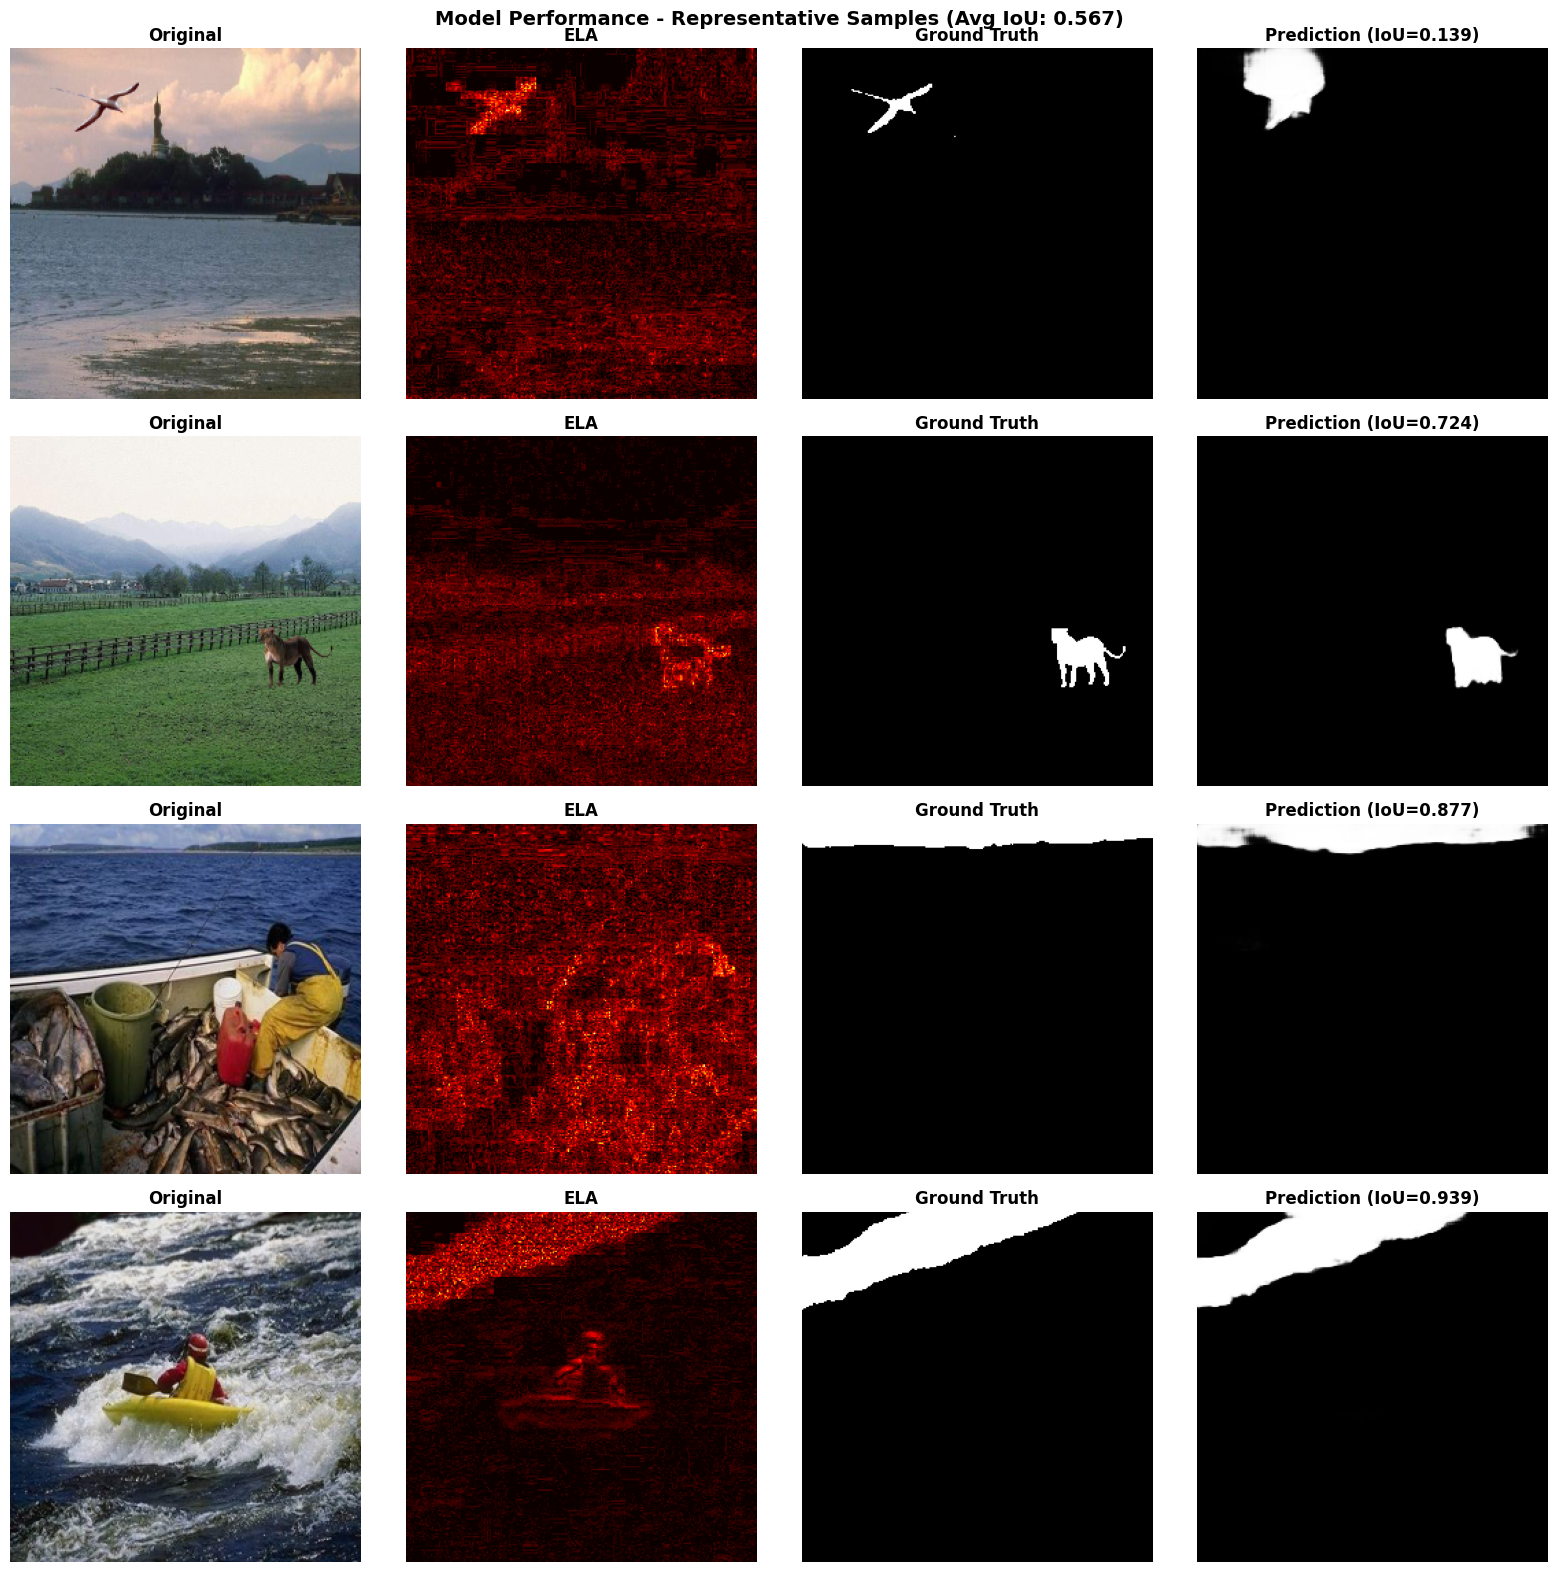


IoU Distribution:
  Mean: 0.567
  Median: 0.724
  25th percentile: 0.139
  75th percentile: 0.876
  Best: 0.993
  Worst: 0.000


In [12]:
# =============================================================================
# Cell 10: Visualization - Select Representative Samples
# =============================================================================

def visualize_best_predictions(model, test_loader, device, num_samples=4):
    """
    Select and visualize samples that represent the model's actual performance
    """
    model.eval()
    
    # Collect all predictions and calculate IoUs
    all_samples = []
    
    with torch.no_grad():
        for data, targets in test_loader:
            data_device = data.to(device)
            outputs = model(data_device)
            predictions = torch.sigmoid(outputs)
            
            # Calculate IoU for each sample
            for i in range(data.shape[0]):
                metrics = calculate_metrics(
                    predictions[i:i+1].cpu(), 
                    targets[i:i+1]
                )
                
                all_samples.append({
                    'data': data[i],
                    'target': targets[i],
                    'prediction': predictions[i].cpu(),
                    'iou': metrics['iou']
                })
    
    # Sort by IoU to find representative samples
    all_samples.sort(key=lambda x: x['iou'])
    
    # Select samples at different percentiles to show range
    total = len(all_samples)
    indices = [
        int(total * 0.25),  # 25th percentile (lower performance)
        int(total * 0.50),  # 50th percentile (median)
        int(total * 0.75),  # 75th percentile (good performance)
        int(total * 0.90),  # 90th percentile (best performance)
    ]
    
    selected_samples = [all_samples[i] for i in indices[:num_samples]]
    
    # Plot
    fig, axes = plt.subplots(num_samples, 4, figsize=(16, 4*num_samples))
    
    if num_samples == 1:
        axes = axes.reshape(1, -1)
    
    for idx, sample in enumerate(selected_samples):
        # Extract RGB
        rgb = sample['data'][:3].numpy()
        rgb = rgb * np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1) + \
              np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        rgb = np.clip(rgb.transpose(1, 2, 0), 0, 1)
        
        # ELA
        ela = sample['data'][3].numpy()
        
        # Ground truth
        gt = sample['target'][0].numpy()
        
        # Prediction
        pred = sample['prediction'][0].numpy()
        
        # Display
        axes[idx, 0].imshow(rgb)
        axes[idx, 0].set_title('Original', fontsize=12, fontweight='bold')
        axes[idx, 0].axis('off')
        
        axes[idx, 1].imshow(ela, cmap='hot')
        axes[idx, 1].set_title('ELA', fontsize=12, fontweight='bold')
        axes[idx, 1].axis('off')
        
        axes[idx, 2].imshow(gt, cmap='gray')
        axes[idx, 2].set_title('Ground Truth', fontsize=12, fontweight='bold')
        axes[idx, 2].axis('off')
        
        axes[idx, 3].imshow(pred, cmap='gray')
        axes[idx, 3].set_title(f'Prediction (IoU={sample["iou"]:.3f})', 
                               fontsize=12, fontweight='bold')
        axes[idx, 3].axis('off')
    
    plt.suptitle(f'Model Performance - Representative Samples (Avg IoU: {np.mean([s["iou"] for s in all_samples]):.3f})',
                 fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig('representative_predictions.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    # Print statistics
    ious = [s['iou'] for s in all_samples]
    print("\nIoU Distribution:")
    print(f"  Mean: {np.mean(ious):.3f}")
    print(f"  Median: {np.median(ious):.3f}")
    print(f"  25th percentile: {np.percentile(ious, 25):.3f}")
    print(f"  75th percentile: {np.percentile(ious, 75):.3f}")
    print(f"  Best: {np.max(ious):.3f}")
    print(f"  Worst: {np.min(ious):.3f}")


# Run this instead of your current visualization
visualize_best_predictions(model, test_loader, DEVICE, num_samples=4)

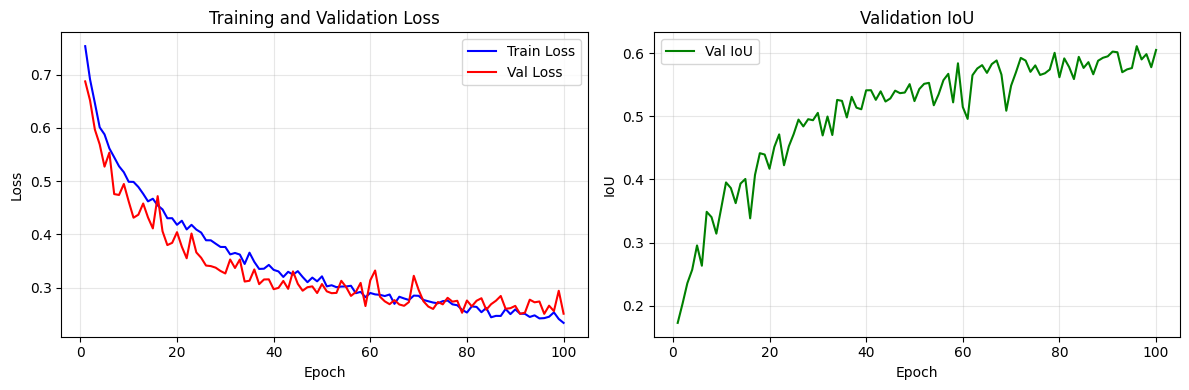

In [13]:
# =============================================================================
# Cell 11: Plot Training History
# =============================================================================

if history['train_loss']:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    
    ax2.plot(epochs, history['val_iou'], 'g-', label='Val IoU')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('IoU')
    ax2.set_title('Validation IoU')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

In [14]:
# =============================================================================
# Cell 12: Save Final Model
# =============================================================================

# Save complete model checkpoint
checkpoint = {
    'model_state_dict': model.state_dict(),
    'config': CONFIG,
    'metrics': avg_metrics,
    'history': history
}

torch.save(checkpoint, 'forgery_detection_final.pth')
print(f"\nModel saved as 'forgery_detection_final.pth'")
print(f"File size: {os.path.getsize('forgery_detection_final.pth') / 1024 / 1024:.2f} MB")


Model saved as 'forgery_detection_final.pth'
File size: 118.50 MB
